In [1]:
# ── A. Imports & Reproducibility ────────────────────────────────────────────────
import os, copy
import csv                                                  # For result logging :contentReference[oaicite:0]{index=0}
import random                                               # For seeding :contentReference[oaicite:1]{index=1}
import numpy as np                                          # For numeric ops :contentReference[oaicite:2]{index=2}
import torch                                               # Core PyTorch :contentReference[oaicite:3]{index=3}
import torch.nn as nn                                       # Neural-net modules :contentReference[oaicite:4]{index=4}
import torch.nn.functional as F                             # Functional API :contentReference[oaicite:5]{index=5}
import torch.optim as optim                                 # Optimizers :contentReference[oaicite:6]{index=6}
from torch.optim.lr_scheduler import CosineAnnealingLR      # Scheduler :contentReference[oaicite:7]{index=7}
from torch.utils.data import DataLoader, random_split       # Data loaders & splits :contentReference[oaicite:8]{index=8}
import torchvision                                          # Datasets & transforms :contentReference[oaicite:9]{index=9}
import torchvision.transforms as T                          # Transforms :contentReference[oaicite:10]{index=10}
from torch.utils.tensorboard import SummaryWriter           # TensorBoard logging :contentReference[oaicite:11]{index=11}
import matplotlib.pyplot as plt                             # Plotting :contentReference[oaicite:12]{index=12}

In [ ]:
multiple_device=False
# Limit this notebook to 30% compute
if multiple_device==True:
    os.environ["CUDA_MPS_ACTIVE_THREAD_PERCENTAGE"] = "40"

if multiple_device==True:
    torch.cuda.set_per_process_memory_fraction(0.4, device=0)

In [3]:
# Seed everything for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


# ── B. Device ───────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")                             # Confirm GPU vs CPU :contentReference[oaicite:13]{index=13}



# ── C. Data Preparation ─────────────────────────────────────────────────────────
# Transforms
transform_train = T.Compose([
    T.RandomCrop(32, padding=4), T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5071,0.4867,0.4408),(0.2675,0.2565,0.2761)),
])
transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5071,0.4867,0.4408),(0.2675,0.2565,0.2761)),
])


Using device: cuda


In [4]:
import glob, torch, os



def latest_ckpt(dirpath, pattern="last_ckpt__round_*.pth"):
    paths = glob.glob(os.path.join(dirpath, pattern))
    if not paths:
        return None
    paths.sort(key=lambda p: int(p.rsplit("_", 1)[1].split(".")[0]))
    return paths[-1]


def load_checkpoint(model, optimizer, ckpt_dir, resume=True,name=""):
    if not resume:
        print("[Checkpoint] Starting training from scratch.")
        return 1
    if name:
        pattern='last_ckpt_'+name+'_round_*.pth'
        ckpt_path = latest_ckpt(ckpt_dir,pattern)
    else:
        ckpt_path = latest_ckpt(ckpt_dir)
    if ckpt_path is None:
        print("[Checkpoint] No checkpoint found; training from scratch.")
        return 1
    # Load checkpoint tensors onto CPU to preserve RNG state tensor
    ckpt = torch.load(ckpt_path, map_location='cpu')
    model.load_state_dict(ckpt['model_state'])
    optimizer.load_state_dict(ckpt['optimizer_state'])
    # Restore CPU RNG state
    rng_state = ckpt['rng_state']
    if rng_state.device.type != 'cpu':
        rng_state = rng_state.cpu()
    torch.set_rng_state(rng_state)
    print(f"[Checkpoint] Resumed from round {ckpt['round']} (loaded {os.path.basename(ckpt_path)})")
    return ckpt['round'] + 1


def save_checkpoint(model, optimizer, round_num, ckpt_dir,personalized_par_string="", is_best=False):
    print(f"[Checkpoint] Saving round {round_num}...")
    state = {
        'round': round_num,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'rng_state': torch.get_rng_state(),
    }
    fname = f"{'best' if is_best else 'last'}_ckpt_{personalized_par_string}_round_{round_num}.pth"
    half_name=f"last_ckpt_{personalized_par_string}_round_"
    if is_best:
        torch.save(model.state_dict(), os.path.join(ckpt_dir,fname))
    else:
            torch.save(state, os.path.join(ckpt_dir, fname))
            for existing in os.listdir(ckpt_dir):
                existing_path = os.path.join(ckpt_dir, existing)
                if (
                    existing.endswith('.pth')
                    and existing != fname
                    and 'best' not in existing
                    and half_name in existing
                ):
                    os.remove(existing_path)
                    print(f"  Deleted: {existing}")
    print(f"[Checkpoint] Done saving to {fname}")


















""" 
def latest_ckpt(dirpath, pattern=None):

    if pattern is None:
        pattern = "*_last_ckpt_round_*.pth"
    paths = glob.glob(os.path.join(dirpath, pattern))
    if not paths:
        return None
    # Extract the round number from each filename, assuming it ends in _<round>.pth
    def round_num(p):
        base = os.path.basename(p)
        # splits on underscores: shard_J{J}_last_ckpt_round_{rnd}.pth
        return int(base.rsplit("_",1)[1].split(".")[0])
    paths.sort(key=round_num)
    return paths[-1]


def load_checkpoint(model, optimizer, ckpt_dir, shard_key, J, resume=True):
    if not resume:
        return 1
    pat = f"{shard_key}_J{J}_last_ckpt_round_*.pth"
    ckpt_path = latest_ckpt(ckpt_dir, pat)
    if ckpt_path is None:
        return 1
    ckpt = torch.load(ckpt_path, map_location='cpu')
    model.load_state_dict(ckpt['model_state'])
    optimizer.load_state_dict(ckpt['optimizer_state'])
    rng_state = ckpt['rng_state']
    if rng_state.device.type != 'cpu':
        rng_state = rng_state.cpu()
    torch.set_rng_state(rng_state)
    return ckpt['round'] + 1



def save_checkpoint(model, optimizer, round_num, ckpt_dir,
                    shard_key, J, is_best=False):

    prefix = f"{shard_key}_J{J}"
    state = {
        'round': round_num,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'rng_state': torch.get_rng_state(),
    }
    # unique filename per config
    last_name = f"{prefix}_last_ckpt_round_{round_num}.pth"
    torch.save(state, os.path.join(ckpt_dir, last_name))
    if is_best:
        best_name = f"{prefix}_best_ckpt.pth"
        torch.save(model.state_dict(), os.path.join(ckpt_dir, best_name))
    print(f"[Checkpoint] Saved {last_name}")
 """

' \ndef latest_ckpt(dirpath, pattern=None):\n\n    if pattern is None:\n        pattern = "*_last_ckpt_round_*.pth"\n    paths = glob.glob(os.path.join(dirpath, pattern))\n    if not paths:\n        return None\n    # Extract the round number from each filename, assuming it ends in _<round>.pth\n    def round_num(p):\n        base = os.path.basename(p)\n        # splits on underscores: shard_J{J}_last_ckpt_round_{rnd}.pth\n        return int(base.rsplit("_",1)[1].split(".")[0])\n    paths.sort(key=round_num)\n    return paths[-1]\n\n\ndef load_checkpoint(model, optimizer, ckpt_dir, shard_key, J, resume=True):\n    if not resume:\n        return 1\n    pat = f"{shard_key}_J{J}_last_ckpt_round_*.pth"\n    ckpt_path = latest_ckpt(ckpt_dir, pat)\n    if ckpt_path is None:\n        return 1\n    ckpt = torch.load(ckpt_path, map_location=\'cpu\')\n    model.load_state_dict(ckpt[\'model_state\'])\n    optimizer.load_state_dict(ckpt[\'optimizer_state\'])\n    rng_state = ckpt[\'rng_state\']\n 

In [5]:
# ── C. Data Preparation ─────────────────────────────────────────────────────────
# Transforms (as before)…

# Download full CIFAR‑100 training set
full_train = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train
)

# 1) Centralized validation split
val_size   = 5000
train_size = len(full_train) - val_size
train_dataset, val_dataset = random_split(
    full_train,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)
)

# ── C.1 Build validation loader ───────────────────────────────
BS_VAL = 256
val_loader = DataLoader(
    val_dataset,
    batch_size=BS_VAL,
    shuffle=False,
    num_workers=2
)

# Ensure test_loader exists (fix NameError from summarize_run)
if 'test_loader' not in globals():
    print("Defining test_loader (was missing).")
    # require transform_test and BS_VAL to be defined
    if 'transform_test' not in globals():
        # fallback: define a default transform (shouldn't happen if you defined it earlier)
        transform_test = T.Compose([
            T.ToTensor(),
            T.Normalize((0.5071,0.4867,0.4408),(0.2675,0.2565,0.2761)),
        ])
    test_dataset = torchvision.datasets.CIFAR100(
        './data', train=False, download=True, transform=transform_test
    )
    test_loader = DataLoader(test_dataset, batch_size=BS_VAL, shuffle=False, num_workers=2)
else:
    print("test_loader already defined in scope.")

# ── C.2 Non-IID Sharding Helper ────────────────────────────────────────────────

from collections import defaultdict, deque
from torch.utils.data import Subset

def create_labelwise_shards(dataset, K, Nc, seed=42):
    # 1) Group indices by label
    label2idx = defaultdict(list)
    for idx, (_, lbl) in enumerate(dataset):
        label2idx[lbl].append(idx)

    # 2) Shuffle each label’s pool
    rng = random.Random(seed)
    for lbl in label2idx:
        rng.shuffle(label2idx[lbl])

    # 3) Prepare an iterator per label
    pointers = {lbl: 0 for lbl in label2idx}

    # 4) Build shards
    samples_per_client = len(dataset) // K
    shards_idx = []
    labels_cycle = list(label2idx.keys())

    for client_id in range(K):
        client_idxs = []
        # Rotate start point so clients don’t always pick the same first label
        rng.shuffle(labels_cycle)
        for lbl in labels_cycle:
            if len(client_idxs) >= samples_per_client:
                break
            # How many to take from this label
            needed = samples_per_client - len(client_idxs)
            available = len(label2idx[lbl]) - pointers[lbl]
            take = min(needed, available)
            if take > 0:
                start = pointers[lbl]
                end   = start + take
                client_idxs.extend(label2idx[lbl][start:end])
                pointers[lbl] += take
        # If we still haven’t reached samples_per_client (rare), fill randomly
        if len(client_idxs) < samples_per_client:
            all_remaining = [i for lbl in label2idx
                                 for i in label2idx[lbl][pointers[lbl]:]]
            client_idxs.extend(rng.sample(all_remaining,
                                          samples_per_client - len(client_idxs)))
        shards_idx.append(client_idxs)

    return [Subset(dataset, idxs) for idxs in shards_idx]


#NEW OUR CONTRIBUTION

# ── C.2 New: Non-IID shards with a random number of classes per client ─────────
from collections import defaultdict
from torch.utils.data import Subset

def create_labelwise_shards_sampled(dataset, K,
                                    min_classes=1, max_classes=50,
                                    sampler='uniform', poisson_lambda=5,
                                    allocation='equal', dirichlet_alpha=1.0,
                                    seed=42):
    """
    Build K disjoint subsets where each client:
      - samples n_classes ~ (uniform[min,max] OR 1+Poisson(lambda))
      - selects those classes (without replacement)
      - receives `target` examples distributed among the chosen classes
        according to `allocation` (equal or dirichlet proportions)
    Guarantees: no example is duplicated across clients and every example assigned.

    Args:
      dataset: torch Dataset (train_dataset)
      K: number of clients
      min_classes, max_classes: bounds for sampled number of classes per client
      sampler: 'uniform' or 'poisson'
      poisson_lambda: lambda for Poisson sampler
      allocation: 'equal' | 'dirichlet' | 'random' (random proportional)
      dirichlet_alpha: alpha parameter for Dirichlet (if allocation == 'dirichlet')
      seed: RNG seed for reproducibility

    Returns:
      list_of_subsets: list of torch.utils.data.Subset objects length K
    """
    # --- Build per-label index pools (deques for efficient popleft) ---
    label2idx = defaultdict(list)
    for idx, (_, lbl) in enumerate(dataset):
        label2idx[lbl].append(idx)
    # shuffle each label's pool reproducibly
    rng_py = random.Random(seed)
    for lbl in label2idx:
        rng_py.shuffle(label2idx[lbl])
    label_deques = {lbl: deque(label2idx[lbl]) for lbl in label2idx}
    labels = list(label_deques.keys())
    n_labels_total = len(labels)

    # --- compute per-client target sizes (balanced remainder) ---
    N = len(dataset)
    base = N // K
    remainder = N % K
    target_sizes = [base + (1 if i < remainder else 0) for i in range(K)]

    # helper: sample number of classes
    def sample_n_classes_local():
        if sampler == 'uniform':
            return rng_py.randint(min_classes, min(max_classes, n_labels_total))
        elif sampler == 'poisson':
            # use numpy's generator seeded with rng_py for reproducibility
            seed_local = rng_py.randint(0, 2**31 - 1)
            n = int(np.random.default_rng(seed_local).poisson(lam=poisson_lambda)) + 1
            return max(min_classes, min(n, min(max_classes, n_labels_total)))
        else:
            return rng_py.randint(min_classes, min(max_classes, n_labels_total))

    # helper: allocate counts across chosen classes given target and allocation scheme
    def allocate_counts(target, n_chosen):
        if n_chosen <= 0:
            return []
        if allocation == 'equal':
            base_share = target // n_chosen
            rem = target % n_chosen
            alloc = [base_share + (1 if i < rem else 0) for i in range(n_chosen)]
            return alloc
        elif allocation == 'dirichlet':
            # sample proportions from Dirichlet(alpha)
            alpha = np.ones(n_chosen) * float(dirichlet_alpha)
            prop = np.random.default_rng(rng_py.randint(0, 2**31-1)).dirichlet(alpha)
            raw = prop * target
            # convert to integer allocation preserving sum==target
            floored = np.floor(raw).astype(int).tolist()
            leftover = target - sum(floored)
            # distribute leftover to largest fractional parts
            fracs = raw - np.floor(raw)
            order = np.argsort(fracs)[::-1]
            for j in range(leftover):
                floored[order[j]] += 1
            return floored
        else:  # 'random' : choose random integer splits (via multinomial)
            rng_seed = rng_py.randint(0, 2**31 - 1)
            props = np.random.default_rng(rng_seed).multinomial(target, [1.0 / n_chosen] * n_chosen)
            return props.tolist()

    # Prepare result list and a randomized client order to mitigate ordering bias
    client_indices = [[] for _ in range(K)]
    client_order = list(range(K))
    rng_py.shuffle(client_order)  # process clients in random order (deterministic from seed)

    # For speed: keep a small lookup of remaining counts per label
    remaining_per_label = {lbl: len(label_deques[lbl]) for lbl in labels}

    for client_id in client_order:
        target = target_sizes[client_id]
        # sample how many classes this client *wants*
        n_classes = sample_n_classes_local()
        n_classes = min(n_classes, n_labels_total)  # safety

        # choose the classes for this client (without replacement)
        # but prefer classes that still have remaining samples: sample from labels weighted by availability
        available_labels = [lbl for lbl in labels if remaining_per_label.get(lbl, 0) > 0]
        if len(available_labels) == 0:
            # no remaining samples anywhere — extremely unlikely
            break

        # If available_labels < n_classes, we will only choose those available; rest will be filled later.
        if len(available_labels) <= n_classes:
            chosen_labels = available_labels[:]
            rng_py.shuffle(chosen_labels)
        else:
            # sample without replacement among available labels
            # use rng_py.sample for reproducibility
            chosen_labels = rng_py.sample(available_labels, k=n_classes)

        # compute desired allocation across chosen_labels
        alloc = allocate_counts(target, len(chosen_labels))

        # Try to fulfill allocation from chosen labels, consuming their deques
        client_taken = []
        shortfall = 0
        for lbl, want in zip(chosen_labels, alloc):
            available = remaining_per_label.get(lbl, 0)
            take = min(want, available)
            for _ in range(take):
                client_taken.append(label_deques[lbl].popleft())
            remaining_per_label[lbl] = remaining_per_label.get(lbl, 0) - take
            if take < want:
                shortfall += (want - take)

        # If there is a shortfall, try to fill it from other labels (scan labels by remaining)
        if shortfall > 0:
            # build a list of labels sorted by remaining count (descending) to fill quickly
            refill_labels = sorted(labels, key=lambda x: remaining_per_label.get(x, 0), reverse=True)
            for lbl in refill_labels:
                if shortfall <= 0:
                    break
                available = remaining_per_label.get(lbl, 0)
                if available <= 0:
                    continue
                take = min(available, shortfall)
                for _ in range(take):
                    client_taken.append(label_deques[lbl].popleft())
                remaining_per_label[lbl] -= take
                shortfall -= take

        # Final safety: if still short (very unlikely), allow sampling from any remaining indices with replacement
        if len(client_taken) < target:
            need = target - len(client_taken)
            all_remaining = []
            for lbl in labels:
                all_remaining.extend(list(label_deques[lbl]))
            if len(all_remaining) >= need and len(all_remaining) > 0:
                # take deterministically from the front of remaining pools
                # and advance pointers (pop left)
                taken_now = all_remaining[:need]
                # Pop these indices from deques by label
                taken_count = 0
                for lbl in labels:
                    while taken_count < need and len(label_deques[lbl]) > 0:
                        client_taken.append(label_deques[lbl].popleft())
                        remaining_per_label[lbl] -= 1
                        taken_count += 1
                        if taken_count >= need:
                            break
            else:
                # fallback: sample with replacement from full index range (shouldn't be necessary)
                rng2 = random.Random(rng_py.randint(0, 2**31 - 1))
                while len(client_taken) < target:
                    client_taken.append(rng2.choice(range(N)))

        # Ensure exact target
        if len(client_taken) > target:
            client_taken = client_taken[:target]
        elif len(client_taken) < target:
            # pad (should not happen) with random indices not yet used if possible
            all_remaining = []
            for lbl in labels:
                all_remaining.extend(list(label_deques[lbl]))
            if len(all_remaining) > 0:
                client_taken += all_remaining[:(target - len(client_taken))]
                # pop them
                taken_rem = target - len(client_taken)
                popped = 0
                for lbl in labels:
                    while popped < taken_rem and len(label_deques[lbl]) > 0:
                        label_deques[lbl].popleft()
                        remaining_per_label[lbl] -= 1
                        popped += 1
                        if popped >= taken_rem:
                            break
            else:
                # absolute last resort: sample from full dataset with replacement
                rng2 = random.Random(rng_py.randint(0, 2**31 - 1))
                while len(client_taken) < target:
                    client_taken.append(rng2.choice(range(N)))

        client_indices[client_id] = client_taken

    # Final check: every example should be assigned exactly once
    all_assigned = [i for lst in client_indices for i in lst]
    if len(all_assigned) != len(set(all_assigned)):
        # Debug info if something went wrong
        dup_count = len(all_assigned) - len(set(all_assigned))
        print(f"[Warning] {dup_count} duplicates detected in assignment (unexpected).")
    if sum(len(lst) for lst in client_indices) != N:
        # Some items may remain unassigned if remainder was mis-handled; append them to last clients
        remaining = []
        for lbl in labels:
            remaining.extend(list(label_deques[lbl]))
        if remaining:
            # distribute remaining to clients with available capacity
            for idx in remaining:
                # find first client with room
                for cid in range(K):
                    if len(client_indices[cid]) < target_sizes[cid]:
                        client_indices[cid].append(idx)
                        break

    # Convert to Subsets
    subsets = [Subset(dataset, idxs) for idxs in client_indices]
    return subsets

# ── Utility: number of unique classes in a Subset ─────────────────────────────────
def subset_num_classes(subset):
    labs = set()
    # subset is a torch.utils.data.Subset pointing to original dataset
    base_ds = subset.dataset
    for idx in subset.indices:
        _, lbl = base_ds[idx]
        labs.add(lbl)
    return len(labs)








# existing:
K = 100
base = train_size // K
sizes = [base] * (K - 1) + [train_size - base * (K - 1)]
iid_shards = random_split(train_dataset, sizes, generator=torch.Generator().manual_seed(seed))

shardings = {'iid': iid_shards}

# Add old non_iid_Nc variants if you want to keep them
"""Nc_list = [1, 5, 10, 50]
for Nc in Nc_list:
    shardings[f'non_iid_{Nc}'] = create_labelwise_shards(train_dataset, K, Nc, seed)"""

# Add new random-classes variants:
shardings['sampled_uniform_1'] = create_labelwise_shards_sampled(
    train_dataset, K,
    min_classes=1, max_classes=2,
    sampler='uniform', allocation='equal', seed=42
)

shardings['sampled_uniform_5'] = create_labelwise_shards_sampled(
    train_dataset, K,
    min_classes=5, max_classes=6,
    sampler='uniform', allocation='equal', seed=42
)

shardings['sampled_uniform_10'] = create_labelwise_shards_sampled(
    train_dataset, K,
    min_classes=10, max_classes=11,
    sampler='uniform', allocation='equal', seed=42
)

shardings['sampled_uniform_50'] = create_labelwise_shards_sampled(
    train_dataset, K,
    min_classes=50, max_classes=51,
    sampler='uniform', allocation='equal', seed=42
)

"""shardings['sampled_poisson'] = create_labelwise_shards_sampled(
    train_dataset, K,
    min_classes=1, max_classes=20,
    sampler='poisson', poisson_lambda=3, allocation='dirichlet', dirichlet_alpha=0.5, seed=42
)"""



100%|██████████| 169M/169M [00:35<00:00, 4.76MB/s] 


Defining test_loader (was missing).


"shardings['sampled_poisson'] = create_labelwise_shards_sampled(\n    train_dataset, K,\n    min_classes=1, max_classes=20,\n    sampler='poisson', poisson_lambda=3, allocation='dirichlet', dirichlet_alpha=0.5, seed=42\n)"

In [6]:
def check_sharding(subsets, name):
    K_check = len(subsets)
    samples_per_client = len(subsets[0].indices)

    print(f"\n=== Checking {name} ===")

    # 1) same size per client
    sizes = [len(s.indices) for s in subsets]
    print("sizes: min, max, unique counts:", min(sizes), max(sizes), set(sizes))

    # 2) no duplicates across clients and coverage
    all_idxs = [i for s in subsets for i in s.indices]
    total_assigned = len(all_idxs)
    unique_assigned = len(set(all_idxs))
    print("total_assigned:", total_assigned, "unique_assigned:", unique_assigned)

    if unique_assigned != total_assigned:
        print("WARNING: some indices are duplicated across clients.")
    else:
        print("OK: no duplicated indices across clients.")

    # 3) full coverage
    N = len(train_dataset)
    print("dataset size N:", N, "K*samples_per_client:", K_check * samples_per_client)
    if K_check * samples_per_client == N:
        print("OK: every example is assigned exactly once.")
    else:
        print("Note: not all examples were assigned (expected if N not divisible by K).")

    # 4) classes per client distribution
    def subset_num_classes(sub):
        base = sub.dataset
        labs = set(base[idx][1] for idx in sub.indices)
        return len(labs)

    classes_per_client = [subset_num_classes(s) for s in subsets]
    print("classes per client: min, max, mean:",
          min(classes_per_client),
          max(classes_per_client),
          sum(classes_per_client)/len(classes_per_client))


# Loop through all shardings with prefix "sampled_uniform"
for name, subsets in shardings.items():
    check_sharding(subsets, name)



=== Checking iid ===
sizes: min, max, unique counts: 450 450 {450}
total_assigned: 45000 unique_assigned: 45000
OK: no duplicated indices across clients.
dataset size N: 45000 K*samples_per_client: 45000
OK: every example is assigned exactly once.
classes per client: min, max, mean: 96 100 98.98

=== Checking sampled_uniform_1 ===
sizes: min, max, unique counts: 450 450 {450}
total_assigned: 45000 unique_assigned: 45000
OK: no duplicated indices across clients.
dataset size N: 45000 K*samples_per_client: 45000
OK: every example is assigned exactly once.
classes per client: min, max, mean: 1 12 2.29

=== Checking sampled_uniform_5 ===
sizes: min, max, unique counts: 450 450 {450}
total_assigned: 45000 unique_assigned: 45000
OK: no duplicated indices across clients.
dataset size N: 45000 K*samples_per_client: 45000
OK: every example is assigned exactly once.
classes per client: min, max, mean: 5 12 6.1

=== Checking sampled_uniform_10 ===
sizes: min, max, unique counts: 450 450 {450}
to

Saved iid_classes_per_client.csv


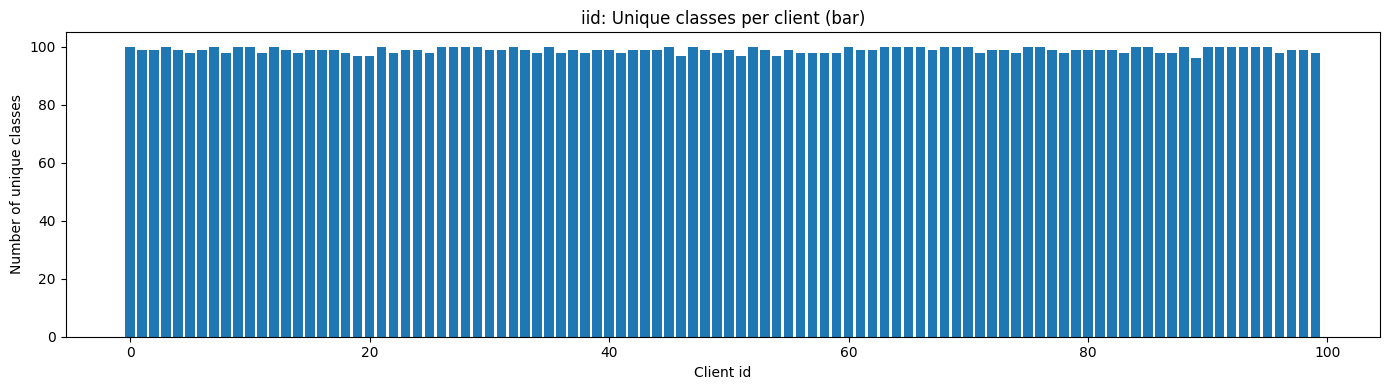

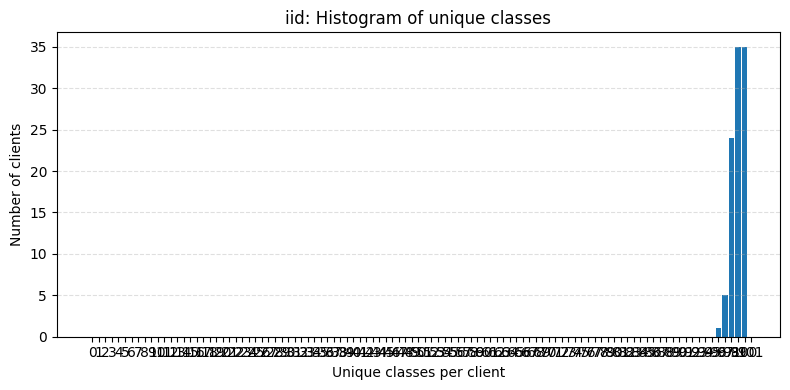

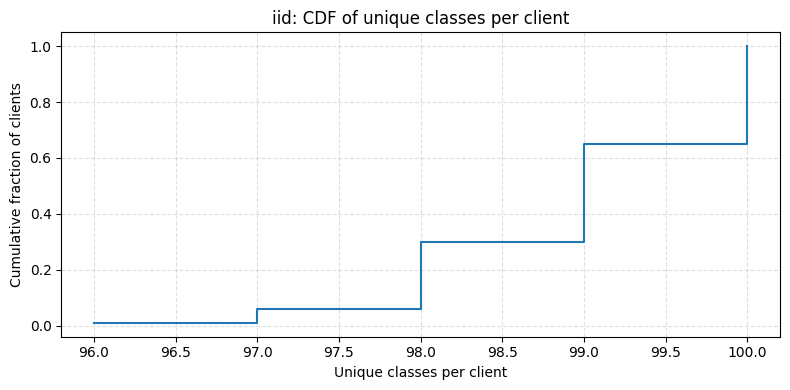


=== iid stats ===
min, max, mean, median, std: 96 100 98.98 99.0 0.9378699270154683

Top 10 clients by number of unique classes:
  client_id  unique_classes
         0             100
         3             100
         9             100
         7             100
        35             100
        29             100
        10             100
        12             100
        28             100
        26             100
Saved sampled_uniform_1_classes_per_client.csv


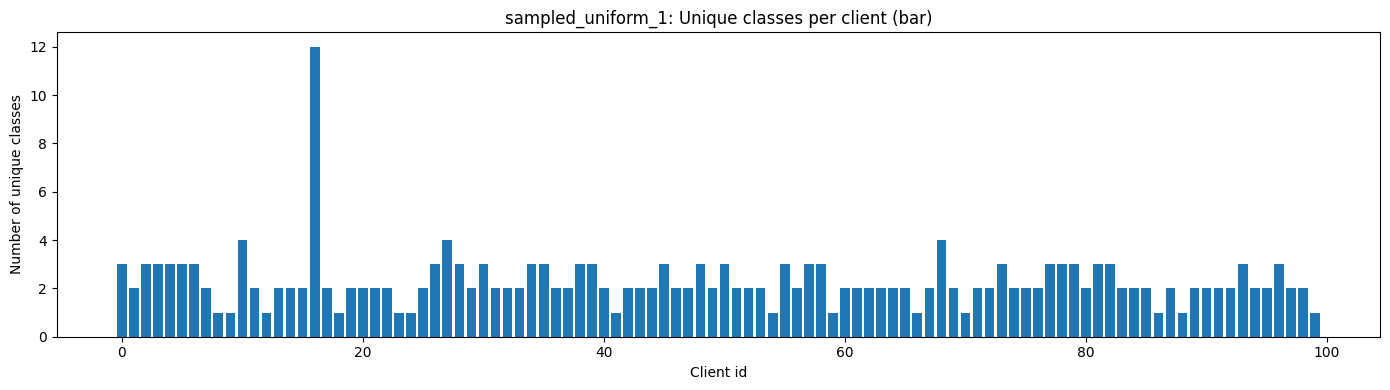

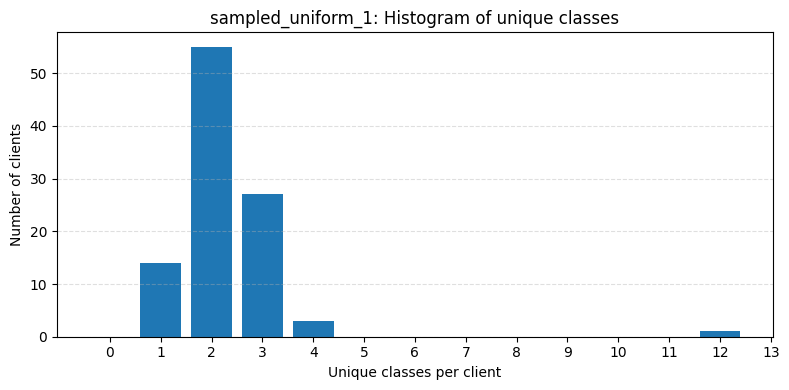

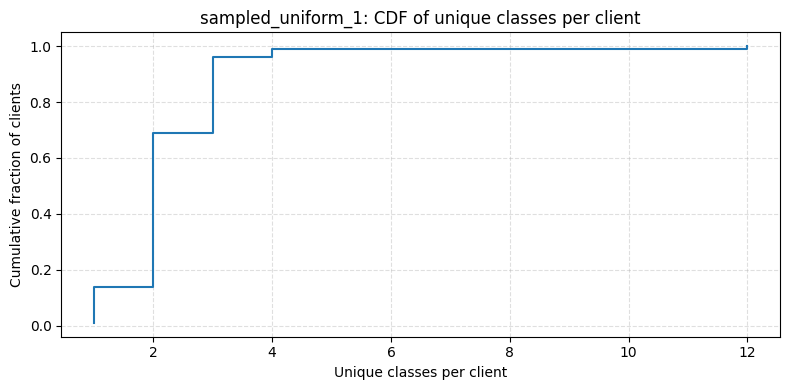


=== sampled_uniform_1 stats ===
min, max, mean, median, std: 1 12 2.29 2.0 1.2024558203942466

Top 10 clients by number of unique classes:
  client_id  unique_classes
        16              12
        10               4
        27               4
        68               4
        28               3
         3               3
         2               3
         6               3
         5               3
        30               3
Saved sampled_uniform_5_classes_per_client.csv


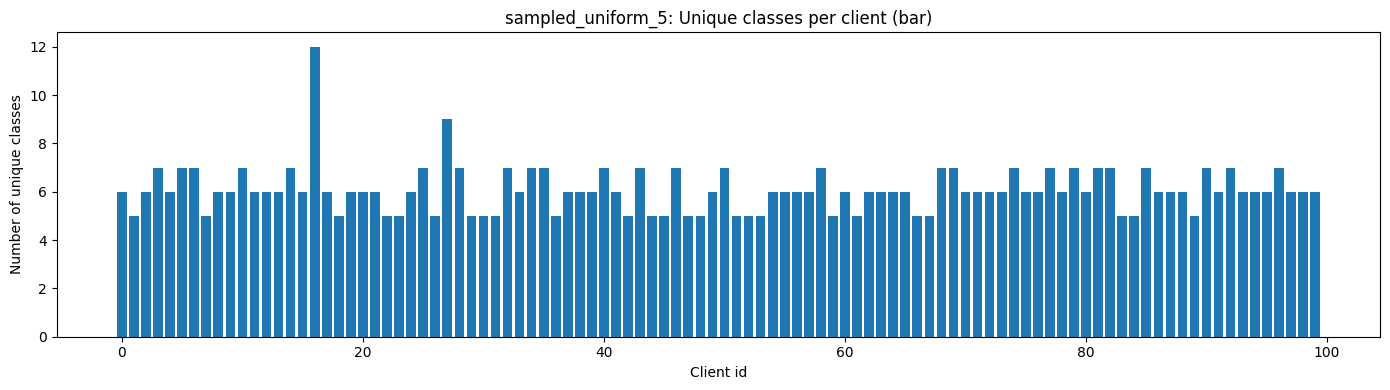

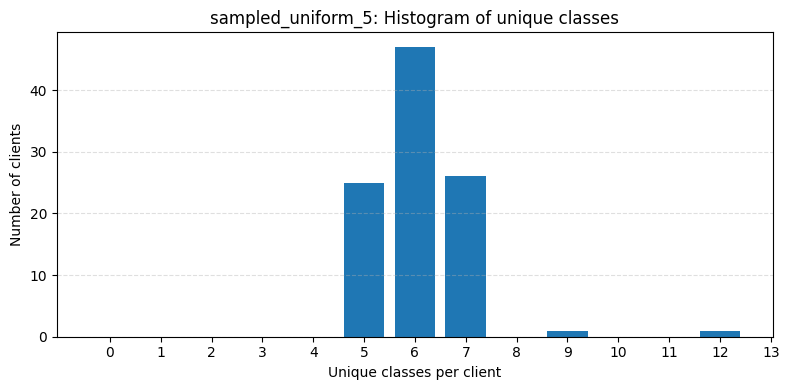

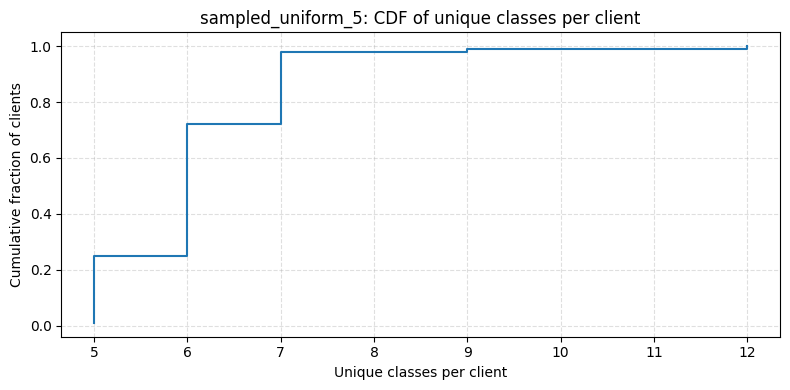


=== sampled_uniform_5 stats ===
min, max, mean, median, std: 5 12 6.1 6.0 0.9746794344808964

Top 10 clients by number of unique classes:
  client_id  unique_classes
        16              12
        27               9
         3               7
        10               7
        28               7
        32               7
        34               7
         5               7
        14               7
        35               7
Saved sampled_uniform_10_classes_per_client.csv


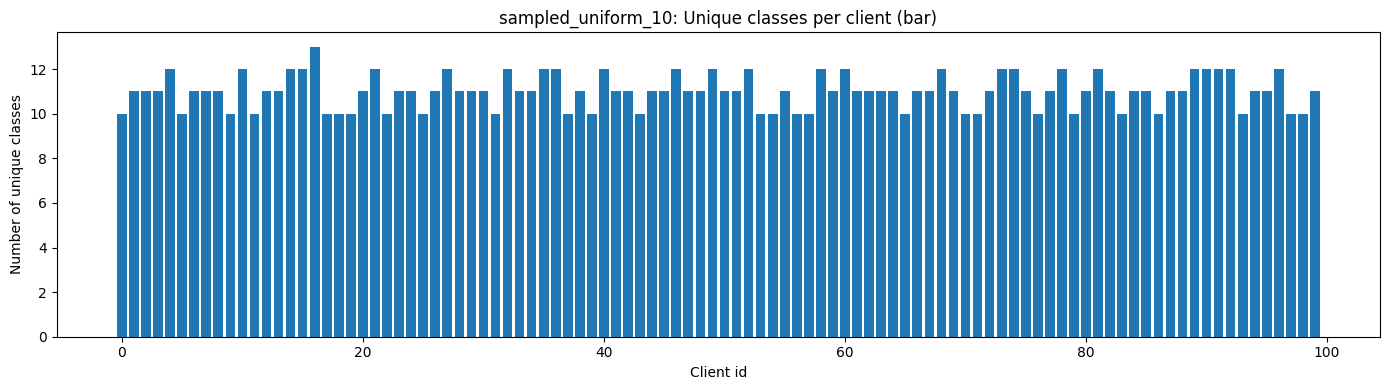

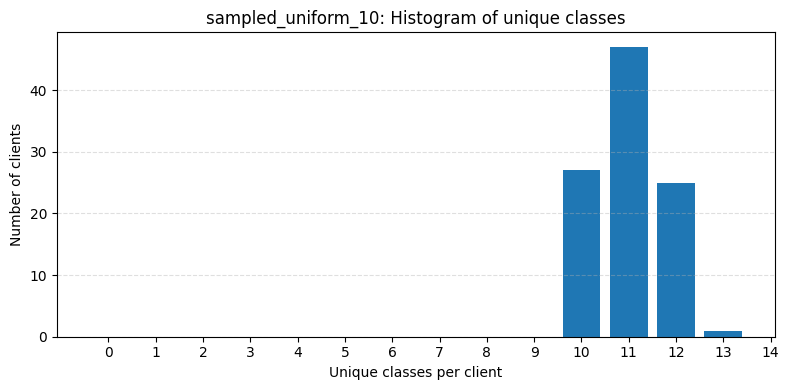

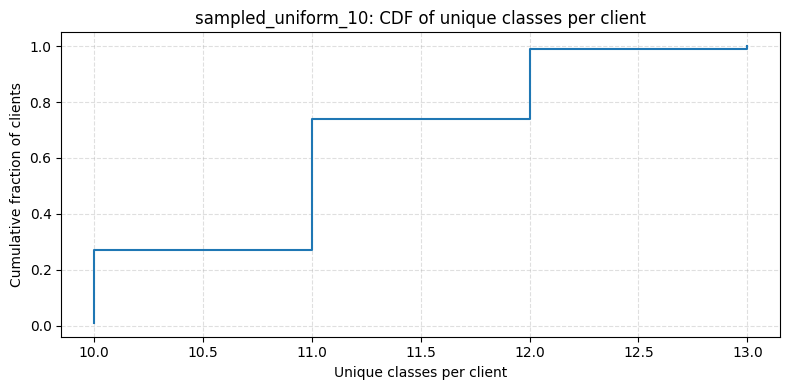


=== sampled_uniform_10 stats ===
min, max, mean, median, std: 10 13 11.0 11.0 0.7483314773547883

Top 10 clients by number of unique classes:
  client_id  unique_classes
        16              13
        10              12
         4              12
        15              12
        35              12
        32              12
        27              12
        21              12
        14              12
        89              12
Saved sampled_uniform_50_classes_per_client.csv


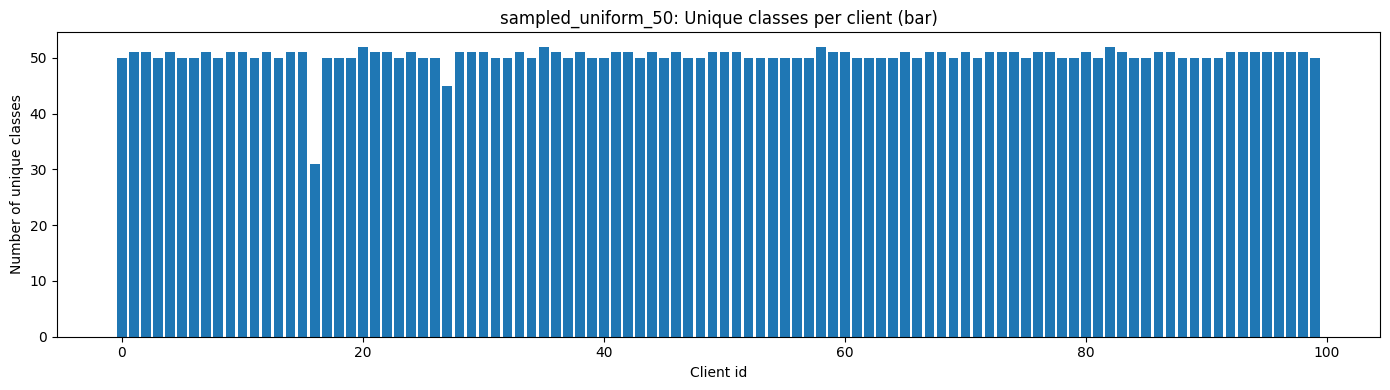

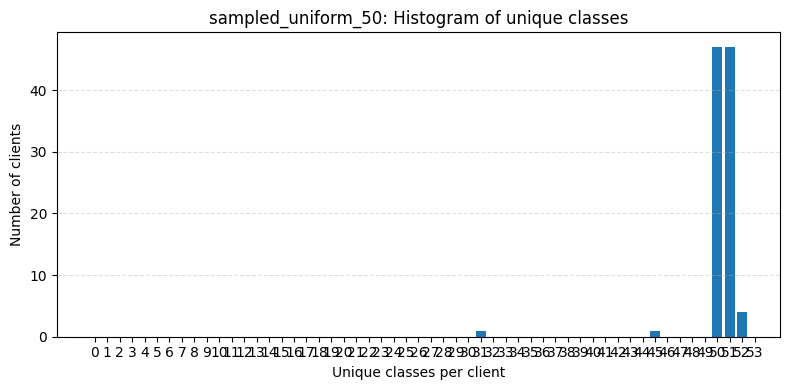

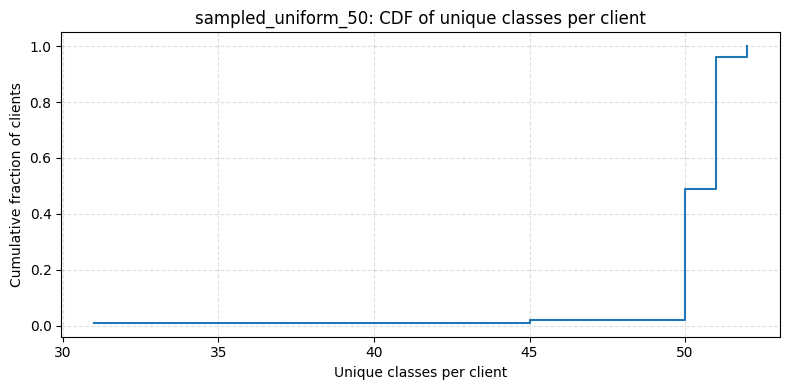


=== sampled_uniform_50 stats ===
min, max, mean, median, std: 31 52 50.31 51.0 2.096163161588333

Top 10 clients by number of unique classes:
  client_id  unique_classes
        20              52
        35              52
        82              52
        58              52
        24              51
        28              51
         4              51
         7              51
        14              51
        15              51


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_classes_per_client(subsets, dataset, name):
    """Analyze and save plots/CSV for unique classes per client."""
    K = len(subsets)

    # compute unique classes per client
    def subset_num_classes(subset, dataset):
        labs = set(dataset[idx][1] for idx in subset.indices)
        return len(labs)

    classes_per_client = [subset_num_classes(s, dataset) for s in subsets]

    # DataFrame
    df = pd.DataFrame({
        'client_id': np.arange(K),
        'unique_classes': classes_per_client
    })
    csv_name = f"{name}_classes_per_client.csv"
    df.to_csv(csv_name, index=False)
    print(f"Saved {csv_name}")

    # 1) Bar plot
    plt.figure(figsize=(14,4))
    plt.bar(df['client_id'], df['unique_classes'])
    plt.xlabel("Client id")
    plt.ylabel("Number of unique classes")
    plt.title(f"{name}: Unique classes per client (bar)")
    plt.tight_layout()
    plt.savefig(f"{name}_bar.png")
    plt.show()
    plt.close()

    # 2) Histogram
    plt.figure(figsize=(8,4))
    max_classes = max(classes_per_client)
    bins = range(0, max_classes+2)
    plt.hist(classes_per_client, bins=bins, align='left', rwidth=0.8)
    plt.xticks(bins)
    plt.xlabel("Unique classes per client")
    plt.ylabel("Number of clients")
    plt.title(f"{name}: Histogram of unique classes")
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.savefig(f"{name}_hist.png")
    plt.show()
    plt.close()

    # 3) CDF
    plt.figure(figsize=(8,4))
    vals_sorted = np.sort(classes_per_client)
    cdf = np.arange(1, K+1) / K
    plt.step(vals_sorted, cdf, where='post')
    plt.xlabel("Unique classes per client")
    plt.ylabel("Cumulative fraction of clients")
    plt.title(f"{name}: CDF of unique classes per client")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.savefig(f"{name}_cdf.png")
    plt.show()
    plt.close()

    # Quick stats
    print(f"\n=== {name} stats ===")
    print("min, max, mean, median, std:",
          np.min(classes_per_client),
          np.max(classes_per_client),
          np.mean(classes_per_client),
          np.median(classes_per_client),
          np.std(classes_per_client))

    # Top clients
    top = df.sort_values('unique_classes', ascending=False).head(10)
    print("\nTop 10 clients by number of unique classes:\n",
          top.to_string(index=False))


# Loop over shardings
for name, subsets in shardings.items():
   analyze_classes_per_client(subsets, train_dataset, name)


In [8]:
# ── D. Model Definition ─────────────────────────────────────────────────────────
class LELeNetCIFAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1   = nn.Linear(64*8*8, 384)
        self.fc2   = nn.Linear(384, 192)
        self.fc3   = nn.Linear(192, 100)
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x)); x = F.relu(self.fc2(x))
        return self.fc3(x)

In [9]:
# ── E. Utilities: Train/Eval & Checkpointing ────────────────────────────────────
def train_one_epoch(model, optimizer, criterion, loader):
    model.train()
    running_loss = correct = total = 0
    for imgs, lbls in loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, lbls)
        loss.backward(); optimizer.step()
        running_loss += loss.item()*imgs.size(0)
        correct += out.argmax(1).eq(lbls).sum().item()
        total += lbls.size(0)
    return running_loss/total, correct/total

def eval_model(model, criterion, loader):
    model.eval()
    running_loss = correct = total = 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs); loss = criterion(out, lbls)
            running_loss += loss.item()*imgs.size(0)
            correct += out.argmax(1).eq(lbls).sum().item()
            total += lbls.size(0)
    return running_loss/total, correct/total


def sample_clients_dirichlet(K, m, gamma, rng):
    """
    Sample m out of K client indices, with probabilities:
      • uniform if gamma == 'uniform'
      • drawn from Dirichlet([gamma]*K) otherwise.
    Returns:
      selected: list of m client indices
      p:        length-K numpy array of sampling probs (sums to 1)
    """
    if gamma == 'uniform':
        p = np.ones(K) / K
    else:
        alpha = np.ones(K) * gamma
        p     = rng.dirichlet(alpha)
    selected = rng.choice(K, size=m, replace=False, p=p)
    return selected.tolist(), p



In [10]:
# ── Configuration Summary & Utilities for FedAvg ──────────────────────────────

import os, sys, platform, time
import torch
import numpy as np
import random
from torch.utils.tensorboard import SummaryWriter



# 3) Hyperparameters
K, C = 100, 0.1
BS, BS_VAL = 128, 256
LR, WD = 0.01, 1e-4
J0, R0   = 4, 2000
budget   = J0 * R0
J_list   = [4, 8, 16]



# 1) Define and instantiate your TensorBoard writer
log_dir = f"./logs/FedAvg_lr{LR}_wd{WD}_bs{BS}"
tb_writer = SummaryWriter(log_dir=log_dir)

# 2) Summary utility
def summarize_run(cfg, client_loaders, test_loader, writer=None):
    """
    Print and log summary for a FedAvg run.
    """
    ts = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    print(f"\n========== FEDAVG RUN SUMMARY ({ts}) ==========")
    # Hyperparameters
    for key in ['lr','weight_decay','batch_size','K','C','J','ROUNDS']:
        print(f"    • {key}: {cfg[key]}")
    # Data info
    num_clients  = len(client_loaders)
    shard_size   = len(client_loaders[0].dataset)
    test_samples = len(test_loader.dataset)
    print(f"    • clients (K): {num_clients}, shard size: {shard_size}")
    print(f"    • test samples: {test_samples}, batch size: {cfg['batch_size']}")
    # Log to TensorBoard
    if writer:
        for key in ['lr','weight_decay','batch_size','K','C','J','ROUNDS']:
            writer.add_text(f'RunInfo/{key}', str(cfg[key]), 0)

# 3) Checkpoint utility
ckpt_dir = './checkpoints'
os.makedirs(ckpt_dir, exist_ok=True)


# ── Example Usage ────────────────────────────────────────────────────────────────

cfg = {
    'lr':           LR,
    'weight_decay': WD,
    'batch_size':   BS,
    'K':            K,
    'C':            C,
    'J0':            J0,
    'ROUNDS':       R0

}



In [11]:
###always copy this for logging ::::::::::::::::::::::::::::::::::::::::::::::::::
import os, csv,json
from datetime import datetime
import pandas as pd


    
def log_results(name, rnd,maxround, val_loss, val_acc, test_loss, test_acc, train_loss, train_acc,local_train_mean,local_train_std, csv_path='results_log.csv',csv_path_final='global_results.csv',params={}):
        file_exists = os.path.exists(csv_path)
        if not file_exists:
            with open(csv_path, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(['name','round', 'val_loss', 'val_acc', 'test_loss', 'test_acc','train_loss', 'train_acc','local_train_mean','local_train_std'])
        with open(csv_path, 'a', newline='') as f:
            csv.writer(f).writerow([
                name,
                rnd,
                f"{val_loss:.4f}", f"{val_acc:.4f}",
                f"{test_loss:.4f}", f"{test_acc:.4f}",
                 f"{train_loss:.4f}",  f"{train_acc:.4f}",
                 f"{local_train_mean:.4f}",  f"{local_train_std:.4f}",

            ])
        

        if rnd==maxround:
                csv_path_res='results_only_'+name+'.csv'
                clean_results_history(csv_path,csv_path_res,name)
                write_final_results(name,params,csv_path_res,csv_path_final)

def clean_results_history(results_file_name,new_file_name,name):   #da fare eliminare righe che vengono prima della successiva 
    input_file = results_file_name
    output_file=new_file_name


    # Read and clean lines
    with open(input_file, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    filtered = []
    last_seen_index = float('inf')  # Start with a very large number
    header = lines[0]
    data_lines = lines[1:]

    # Iterate in reverse
    for line in reversed(data_lines):
        current_index = int(line.split(',')[1])
        if current_index < last_seen_index and (line.split(',')[0]==name):
            filtered.append(line)
            last_seen_index = current_index
        else:
            # Skip this line, as its index is higher than the next one
            pass

    # Reverse again to restore original order (except removed lines)
    filtered.reverse()

    file_exists = os.path.exists(output_file)
    # Write to output


    if os.path.exists(new_file_name):
        with open(new_file_name, "r") as f:
            history_lines = [line.strip() for line in f if line.strip()]
        history_header = history_lines[0]
        history_data = history_lines[1:]
    else:
        history_header = header
        history_data = []

    # --- Remove from history any round that will be updated ---
    new_rounds_set = {int(line.split(',')[1]) for line in filtered}
    updated_history_data = [
        line for line in history_data
        if int(line.split(',')[1]) not in new_rounds_set
    ]

    # --- Merge history and new data ---
    merged_data = updated_history_data + filtered

    # --- Write back ---
    with open(new_file_name, "w") as f:
        f.write(history_header + "\n")
        f.write("\n".join(merged_data))
        f.write("\n")

    print(f"Filtered and merged results written to {new_file_name}")

    """ if file_exists:
        with open(output_file, "a") as f:
            f.write('\n'.join(filtered) )


    else:

        with open(output_file, "w") as f:
            f.write(header+"\n")

            f.write('\n'.join(filtered))
            f.write('\n')

    
    

    

    print(f"Filtered results written to {output_file}") """



def get_results(csv_path):
    df = pd.read_csv(csv_path)

    results = {}

    for split in ['train', 'val', 'test']:
        acc_col = f"{split}_acc"
        loss_col = f"{split}_loss"

        max_acc = df[acc_col].max()
        max_idx = df[acc_col].idxmax()

        max_round = df.loc[max_idx, 'round']
        loss_at_max = df.loc[max_idx, loss_col]

        results[split] = {
            'max_acc': max_acc,
            'round': int(max_round),
            'loss_at_max': loss_at_max
        }

    return results





def write_final_results(name, params, csv_path='results_log.csv', results_csv_path='global_results.csv'):
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    results = get_results(csv_path)

    row = {
        'timestamp': timestamp,
        'model_name': name,
        'parameters': json.dumps(params),
        'train_max_acc': results['train']['max_acc'],
        'train_round': results['train']['round'],
        'train_loss': results['train']['loss_at_max'],
        'val_max_acc': results['val']['max_acc'],
        'val_round': results['val']['round'],
        'val_loss': results['val']['loss_at_max'],
        'test_max_acc': results['test']['max_acc'],
        'test_round': results['test']['round'],
        'test_loss': results['test']['loss_at_max'],
    }

    file_exists = os.path.exists(results_csv_path)

    with open(results_csv_path, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=row.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(row)


In [ ]:
import os

# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    CKPT_DIR = '/content/drive/MyDrive/fl_checkpoints'
else:
    CKPT_DIR = './fl_checkpoints'

os.makedirs(CKPT_DIR, exist_ok=True)



# Set this to True to resume from the last checkpoint; False to start from scratch
RESUME = True



# 3) Hyperparameters
K, C = 100, 0.1
BS, BS_VAL = 128, 256
LR, WD = 0.01, 1e-4
J0, R0   = 4, 2000
budget   = J0 * R0
#[4, 8, 16]

# 4) Transforms & Data
transform_train = T.Compose([
    T.RandomCrop(32, 4), T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5071,0.4867,0.4408),(0.2675,0.2565,0.2761)),
])
transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5071,0.4867,0.4408),(0.2675,0.2565,0.2761)),
])

full_train = torchvision.datasets.CIFAR100(
    './data', train=True, download=True, transform=transform_train
)
val_size   = 5000
train_size = len(full_train) - val_size
train_dataset, val_dataset = random_split(
    full_train, [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)
)
val_loader = DataLoader(val_dataset, batch_size=BS_VAL, shuffle=False, num_workers=2)

test_dataset = torchvision.datasets.CIFAR100(
    './data', train=False, download=True, transform=transform_test
)
test_loader = DataLoader(test_dataset, batch_size=BS_VAL, shuffle=False, num_workers=2)



# ── Instantiate TensorBoard writer ──────────────────────────────────────────────
from torch.utils.tensorboard import SummaryWriter
log_dir   = f"./logs/FedAvg_lr{LR}_wd{WD}_bs{BS}"
tb_writer = SummaryWriter(log_dir=log_dir)

# ── B. CSV Logging Setup ────────────────────────────────────────────────────────
import csv, os
csv_path = './fedavg_results.csv'



# ── B. CSV Logging Setup ────────────────────────────────────────────────────────
import csv, os
csv_path = './fedavg_results.csv'
if not os.path.exists(csv_path):
    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            'round',
            'val_loss', 'val_acc',
            'test_loss', 'test_acc'
        ])

# Before your FedAvg loop: Instantiate the global model, loss, and client loaders once


# 6) Build all shardings
base = train_size // K
sizes = [base]*(K-1) + [train_size-base*(K-1)]


cfg = {'lr': LR, 'weight_decay': WD, 'batch_size': BS, 'K': K, 'C': C}





rng = np.random.default_rng(seed)





# ── C. FedAvg Training Loop ─────────────────────────────────────────────────────
# ── F. FedAvg Experiment Loop with Drive Checkpoints ──────────────────────────
# Assumes `shardings`, `J_list`, `budget`, `load_checkpoint`, `save_checkpoint`, etc. are defined

# ── D: Training Loop ────────────────────────────────────────────────────────────
all_results = {}

shard_keys_to_run = ['iid'] 
J_list   = [4]

for shard_key in shard_keys_to_run:
    shards = shardings[shard_key]
    client_loaders = [
        DataLoader(shards[i], batch_size=BS, shuffle=True, num_workers=2)
        for i in range(K)
    ]

    for J in J_list:
        for gamma in [0.01,0.1,0.5,1,10]:
            name=f"test_sampled_gamma_{str(gamma)}_J_4"
            ROUNDS_scaled = budget // J
            cfg.update({'J': J, 'ROUNDS': ROUNDS_scaled})
            summarize_run(cfg, client_loaders, test_loader, writer=tb_writer)

            # Initialize model & optimizer, then resume if any
            model     = LELeNetCIFAR().to(device)
            optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=WD)
            criterion = nn.CrossEntropyLoss()
            start_round = load_checkpoint(
                model, optimizer,
                ckpt_dir=CKPT_DIR,
                name=name,
                resume=RESUME
            )

            acc_hist = []
            print(f"[{shard_key}|J={J}|gamma={str(gamma)}] Starting from round {start_round}/{ROUNDS_scaled}")

            for rnd in range(start_round, ROUNDS_scaled + 1):
                m = max(1, int(C * K))
                selected, _ = sample_clients_dirichlet(K, m, gamma=gamma, rng=rng)

                # Local updates
                local_accuracies = []
                local_states, sizes = [], []
                for cid in selected:
                    cm    = copy.deepcopy(model)
                    opt_c = optim.SGD(cm.parameters(), lr=LR, momentum=0.9, weight_decay=WD)
                    for _ in range(J):
                        train_loss, train_acc = train_one_epoch(cm, opt_c, criterion, client_loaders[cid])
                    local_states.append(cm.state_dict())
                    sizes.append(len(shards[cid]))
                    local_accuracies.append(train_acc)


                # Compute local mean & std
                local_mean = np.mean(local_accuracies)
                local_std  = np.std(local_accuracies)

                # Aggregate
                total = sum(sizes)
                new_st = {
                    k: sum((sizes[i] / total) * local_states[i][k] for i in range(len(sizes)))
                    for k in model.state_dict()
                }
                model.load_state_dict(new_st)

                # Eval
                _, val_acc = eval_model(model, criterion, val_loader)
                acc_hist.append(val_acc)

                # 4) Evaluation
                val_loss, val_acc   = eval_model(model, criterion, val_loader)
                test_loss, test_acc = eval_model(model, criterion, test_loader)
                acc_hist.append(test_acc)




                
                log_results(name, rnd, ROUNDS_scaled, val_loss, val_acc, test_loss, test_acc, -1, -1,local_mean,local_std, params=cfg,csv_path="le_nouveaux_log.csv",csv_path_final="le_nouveaux_global.csv")


                print(
                    f"[{shard_key} | J={J}] Round {rnd}/{ROUNDS_scaled} "
                    #f"Time={round_time:.1f}s | "
                    f"Local Acc={local_mean:.3f}±{local_std:.3f} | "
                    f"Val Acc={val_acc:.3f} | Test Acc={test_acc:.3f}"
                )



                # Checkpoint every 20 rounds (or at first)
                if rnd == start_round or rnd % 20 == 0:
                # 1) Log a header with the current config and round
                    print(f"[{shard_key} | J={J}] Checkpointing at round {rnd}/{ROUNDS_scaled}")

                    # 2) Print the latest metrics
                    print(f"    → Last Val Acc: {val_acc:.4f} | Last Val Loss: {val_loss:.4f}")
                    print(f"    → Last Test Acc: {test_acc:.4f} | Last Test Loss: {test_loss:.4f}")

                    # 3) Save the checkpoint
                    save_checkpoint(
                        model, optimizer,
                        round_num=rnd,
                        ckpt_dir=CKPT_DIR,
                        personalized_par_string=name,
                        is_best=False
                    )
                print(f"[{shard_key} | J={J}] Checkpoint saved.\n")






















========== FEDAVG RUN SUMMARY (2025-08-24 23:37:42) ==========
    • lr: 0.01
    • weight_decay: 0.0001
    • batch_size: 128
    • K: 100
    • C: 0.1
    • J: 16
    • ROUNDS: 500
    • clients (K): 100, shard size: 450
    • test samples: 10000, batch size: 128
[Checkpoint] Resumed from round 22 (loaded last_ckpt_sampled_uniform_5_J16_round_22.pth)
[sampled_uniform_5|J=16] Starting from round 23/500
[sampled_uniform_5 | J=16] Round 23/500 Local Acc=0.799±0.044 | Val Acc=0.100 | Test Acc=0.100
[sampled_uniform_5 | J=16] Checkpointing at round 23/500
    → Last Val Acc: 0.1000 | Last Val Loss: 4.3422
    → Last Test Acc: 0.1002 | Last Test Loss: 4.2817
[Checkpoint] Saving round 23...
  Deleted: last_ckpt_sampled_uniform_5_J16_round_22.pth
[Checkpoint] Done saving to last_ckpt_sampled_uniform_5_J16_round_23.pth
[sampled_uniform_5 | J=16] Checkpoint saved.

[sampled_uniform_5 | J=16] Round 24/500 Local Acc=0.773±0.067 | Val Acc=0.081 | Test Acc=0.097
[sampled_uniform_5 | J=16] Round 2

KeyboardInterrupt: 

In [ ]:
shard_keys_to_run = ['iid','sampled_uniform_1','sampled_uniform_5','sampled_uniform_50','sampled_uniform_10'] # # or ['non_iid_random_poisson_1_20'], or both
J_list   = [4,8,16]
for shard_key in shard_keys_to_run:
    shards = shardings[shard_key]
    client_loaders = [
        DataLoader(shards[i], batch_size=BS, shuffle=True, num_workers=2)
        for i in range(K)
    ]

    for J in J_list:
        ROUNDS_scaled = budget // J
        cfg.update({'J': J, 'ROUNDS': ROUNDS_scaled})
        summarize_run(cfg, client_loaders, test_loader, writer=tb_writer)

        # Initialize model & optimizer, then resume if any
        model     = LELeNetCIFAR().to(device)
        optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=WD)
        criterion = nn.CrossEntropyLoss()
        start_round = load_checkpoint(
            model, optimizer,
            ckpt_dir=CKPT_DIR,
            name=shard_key+"_J"+str(J),
            resume=RESUME
        )

        acc_hist = []
        print(f"[{shard_key}|J={J}] Starting from round {start_round}/{ROUNDS_scaled}")

        for rnd in range(start_round, ROUNDS_scaled + 1):
            m = max(1, int(C * K))
            selected, _ = sample_clients_dirichlet(K, m, gamma='uniform', rng=rng)

            # Local updates
            local_accuracies = []
            local_states, sizes = [], []
            for cid in selected:
                cm    = copy.deepcopy(model)
                opt_c = optim.SGD(cm.parameters(), lr=LR, momentum=0.9, weight_decay=WD)
                for _ in range(J):
                    train_loss, train_acc = train_one_epoch(cm, opt_c, criterion, client_loaders[cid])
                local_states.append(cm.state_dict())
                sizes.append(len(shards[cid]))
                local_accuracies.append(train_acc)


            # Compute local mean & std
            local_mean = np.mean(local_accuracies)
            local_std  = np.std(local_accuracies)

            # Aggregate
            total = sum(sizes)
            new_st = {
                k: sum((sizes[i] / total) * local_states[i][k] for i in range(len(sizes)))
                for k in model.state_dict()
            }
            model.load_state_dict(new_st)

            # Eval
            _, val_acc = eval_model(model, criterion, val_loader)
            acc_hist.append(val_acc)

            # 4) Evaluation
            val_loss, val_acc   = eval_model(model, criterion, val_loader)
            test_loss, test_acc = eval_model(model, criterion, test_loader)
            acc_hist.append(test_acc)




            
            log_results("test_"+shard_key+"_J_"+str(J), rnd, ROUNDS_scaled, val_loss, val_acc, test_loss, test_acc, -1, -1,local_mean,local_std, params=cfg,csv_path="le_nouveaux_log.csv",csv_path_final="le_nouveaux_global.csv")


            print(
                f"[{shard_key} | J={J}] Round {rnd}/{ROUNDS_scaled} "
                #f"Time={round_time:.1f}s | "
                f"Local Acc={local_mean:.3f}±{local_std:.3f} | "
                f"Val Acc={val_acc:.3f} | Test Acc={test_acc:.3f}"
            )



            # Checkpoint every 20 rounds (or at first)
            if rnd == start_round or rnd % 20 == 0:
              # 1) Log a header with the current config and round
              print(f"[{shard_key} | J={J}] Checkpointing at round {rnd}/{ROUNDS_scaled}")

              # 2) Print the latest metrics
              print(f"    → Last Val Acc: {val_acc:.4f} | Last Val Loss: {val_loss:.4f}")
              print(f"    → Last Test Acc: {test_acc:.4f} | Last Test Loss: {test_loss:.4f}")

              # 3) Save the checkpoint
              save_checkpoint(
                  model, optimizer,
                  round_num=rnd,
                  ckpt_dir=CKPT_DIR,
                  personalized_par_string=shard_key+"_J"+str(J),
                  is_best=False
              )
              print(f"[{shard_key} | J={J}] Checkpoint saved.\n")


        all_results[(shard_key, J)] = np.array(acc_hist)



In [ ]:
#ATTENZIONE!!!!
#OCCHIO A RUNNAREEEE



#utility function that deletes all checkpoints from the checkpoint folder

""" def clear_checkpoints(ckpt_dir):

    removed = 0
    for fname in os.listdir(ckpt_dir):
        path = os.path.join(ckpt_dir, fname)
        if os.path.isfile(path):
            os.remove(path)
            removed += 1
    print(f"[Checkpoint] Cleared {removed} files from {ckpt_dir}")


clear_checkpoints(CKPT_DIR)
 """